## logCPM & Histone Code Analysis of Variance

In [1]:
library(dplyr)
library(egg)
library(ggplot2)
library(GenomicRanges)
library(magrittr)
library(reshape2)
library(scales)
library(targets)
library(tibble)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: ggplot2

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,

In [2]:
pdfFonts(sans = pdfFonts()$Helvetica)
postscriptFonts(sans = postscriptFonts()$Helvetica)
theme_set(
  theme_bw() +
    theme(
      axis.text = element_text(color = "#000000", size = rel(1.2)),
      axis.title = element_text(size = rel(1.2)),
      legend.position = "none",
      panel.background = element_rect(fill="transparent"),
      # We want the facet text to appear as a title of the graphic. Not as a
      # detail akin to the axis break labels!
      strip.text = element_text(size = ggplot2::rel(1.2))
    )
)

In [3]:
setwd("~/Upd-Germline-Genomics")

In [4]:
# tar_load(matches("chic.experiment.quantify.smooth_bw40.*chr$"))
tar_load(chic.gene.enrichment.l2fc)
# tar_load(chic.gene.tss.diameter_40_chr)
tar_load(quartile.factor_Germline)
tar_load(quartile.factor_Somatic)
tar_load(Upd_cpm)

In [5]:
print(tibble(chic.gene.enrichment.l2fc, as_tibble(Upd_cpm)), n=5, width=1000)

# A tibble: 17,558 × 17
  symbol         flybase       chr    start    end strand H3K4_Germline
  <chr>          <chr>         <chr>  <int>  <int> <chr>          <dbl>
1 H3-GFP         ""            NA        NA     NA NA            NA    
2 lncRNA:CR40469 "FBgn0058469" X     122493 122706 +             -0.450
3 CG17636        "FBgn0025837" X     124370 126714 -              0.298
4 RhoGAP1A       "FBgn0025836" X     127449 140340 +              0.768
5 mir-4915       "FBgn0263567" X     133385 133502 +              0.210
  H3K27_Germline H3K9_Germline H3K4_Somatic H3K27_Somatic H3K9_Somatic germline
           <dbl>         <dbl>        <dbl>         <dbl>        <dbl>    <dbl>
1         NA            NA           NA         NA              NA       230.  
2         -0.769         0.373        1.81       3.43e-10       10         2.37
3         -0.823         0.216       -0.527     -1.23e- 1       -0.579     1.01
4         -1.77         -0.462        0.662     -1.72e+ 0       -1.01   

In [22]:
library(spatstat.univar)
log2 <- \(x) log(x) / log(2)
tracks <- sapply(
  c(
    "chic.experiment.quantify.smooth_bw40_H3K4_Germline_CN_chr",
    "chic.experiment.quantify.smooth_bw40_H3K27_Germline_CN_chr",
    "chic.experiment.quantify.smooth_bw40_H3K9_Germline_CN_chr",
    "chic.experiment.quantify.smooth_bw40_H3K4_Somatic_CN_chr",
    "chic.experiment.quantify.smooth_bw40_H3K27_Somatic_CN_chr",
    "chic.experiment.quantify.smooth_bw40_H3K9_Somatic_CN_chr"
  ),
  \(n) {
    track <- get(n)
    data <- elementMetadata(track)
    score <- (data[, 2] / data[, 1]) %>%
      # replace(data[, 1] < 0.1, NA) %>%
      log2()
  }
) %>%
  as_tibble()
weights <- sapply(
  c(
    "chic.experiment.quantify.smooth_bw40_H3K4_Germline_CN_chr",
    "chic.experiment.quantify.smooth_bw40_H3K27_Germline_CN_chr",
    "chic.experiment.quantify.smooth_bw40_H3K9_Germline_CN_chr",
    "chic.experiment.quantify.smooth_bw40_H3K4_Somatic_CN_chr",
    "chic.experiment.quantify.smooth_bw40_H3K27_Somatic_CN_chr",
    "chic.experiment.quantify.smooth_bw40_H3K9_Somatic_CN_chr"
  ),
  \(n) {
    track <- get(n)
    elementMetadata(track)[, 1]
  }
) %>%
  as_tibble()
colnames(tracks) <- c(
  "H3K4_Germline",
  "H3K27_Germline",
  "H3K9_Germline",
  "H3K4_Somatic",
  "H3K27_Somatic",
  "H3K9_Somatic"
)
print(dim(tracks))
assay.meta.data <- as_tibble(read.csv("scRNA-seq-Assay-Metadata.csv"))
enrichment_new <- tibble(
  symbol = assay.meta.data$X,
  mapply(
    \(tr, w) tibble(chic.gene.tss.diameter_40_chr, L2FC = tr[loc]) %>%
      group_by(symbol) %>%
      summarise(
        # L2FC = max(c(-Inf, L2FC), na.rm=T)
        L2FC = ewcdf(
          tr %>% subset(is.finite(tr)),
          weights = w %>% subset(is.finite(tr))
        )(
          0.975
        )
      ) %>%
      arrange(match(symbol, assay.meta.data$X)) %>%
      pull(L2FC) %>%
      replace(!is.finite(.), NA),
    tracks,
    weights
  ) %>%
    as_tibble()
)
print(enrichment_new)

[1] 6883112       6


In [6]:
marks <- data.frame(
  celltype = c("Germline", "Somatic") %>% factor(., .) %>% rep(each = 3 * nrow(Upd_cpm)),
  mark = c("H3K4me3", "H3K27me3", "H3K9me3") %>% factor(., .) %>% rep(each = nrow(Upd_cpm)),
  melt(chic.gene.enrichment.l2fc[7:12], variable.name = "group", value.name = "L2FC"),
  logCPM = c(
    rep(log(Upd_cpm[, "germline"]) / log(10), 3) %>%
      replace(!is.finite(.), NA),
    rep(log(Upd_cpm[, "somatic"]) / log(10), 3) %>%
      replace(!is.finite(.), NA)
  ),
  color = c(
    rep(quartile.factor_Germline, 3),
    rep(quartile.factor_Somatic, 3)
  ) %>%
    structure(levels = c("off", "low", "medium", "high"), class = "factor")
) %>%
  tibble() %>%
  print()

No id variables; using all as measure variables



# A tibble: 105,348 × 6
   celltype mark    group            L2FC   logCPM color 
   <fct>    <fct>   <fct>           <dbl>    <dbl> <fct> 
 1 Germline H3K4me3 H3K4_Germline NA       2.36    high  
 2 Germline H3K4me3 H3K4_Germline -0.450   0.374   off   
 3 Germline H3K4me3 H3K4_Germline  0.298   0.00598 off   
 4 Germline H3K4me3 H3K4_Germline  0.768   1.40    medium
 5 Germline H3K4me3 H3K4_Germline  0.210  NA       off   
 6 Germline H3K4me3 H3K4_Germline -1.03    0.806   low   
 7 Germline H3K4me3 H3K4_Germline  0.0912  0.328   off   
 8 Germline H3K4me3 H3K4_Germline  0.443  -0.294   off   
 9 Germline H3K4me3 H3K4_Germline -0.0860  0.0128  off   
10 Germline H3K4me3 H3K4_Germline  0.0784  0.794   low   
# ℹ 105,338 more rows


In [62]:
logCPM_constant <- marks$logCPM[marks$mark == "H3K4me3"] %>%
  split(marks$celltype[marks$mark == "H3K4me3"])
weighted_membership_coef <- tibble(
  subset(marks, mark == "H3K4me3", select = c(celltype, color, logCPM))
) %>%
  group_by(celltype, color) %>%
  summarise(mu = mean(logCPM, na.rm=T), sd = sd(logCPM, na.rm=T))
weighted_membership <- weighted_membership_coef %>%
  group_by(celltype) %>%
  reframe(
    mapply(
      \(mu, sd) dnorm(logCPM_constant[[celltype[1]]], mu, sd), mu, sd
    ) %>%
      matrix(nrow = nrow(.), ncol = ncol(.), dimnames = list(NULL, color)) %>%
      as_tibble()
  )
weighted_membership_range <- tibble(
  subset(marks, mark == "H3K4me3", select = c(celltype, color, logCPM))
) %>%
  group_by(celltype, color) %>%
  summarise(lower = min(logCPM, na.rm=T), upper = max(logCPM, na.rm=T))
weighted_membership <- weighted_membership_range %>%
  group_by(celltype) %>%
  reframe(
    mapply(
      \(lower, upper) ifelse(
        between(logCPM_constant[[celltype[1]]], lower, upper),
        (1 - abs((logCPM_constant[[celltype[1]]] - lower) / (upper - lower) * 2 - 1)^3)^3,
        0
      ),
      lower, upper
    ) %>%
      matrix(nrow = nrow(.), ncol = ncol(.), dimnames = list(NULL, color)) %>%
      as_tibble()
  )
pearson <- tibble(
  marks,
  weighted_membership %>%
    dplyr::slice(
      c(
        rep(seq_along(logCPM_constant$Germline), 3),
        rep(length(logCPM_constant$Germline) + seq_along(logCPM_constant$Somatic), 3)
      )
    ) %>%
    subset(select=-celltype)
) %>%
  mutate(
    logCPM = logCPM %>% replace(!is.finite(logCPM) | !is.finite(L2FC), NA),
    L2FC = L2FC %>% replace(!is.finite(logCPM) | !is.finite(L2FC), NA),
  ) %>%
  group_by(celltype, mark) %>%
  summarise(
    mu_logCPM_off = weighted.mean(logCPM, off, na.rm=T),
    mu_logCPM_low = weighted.mean(logCPM, low, na.rm=T),
    mu_logCPM_medium = weighted.mean(logCPM, medium, na.rm=T),
    mu_logCPM_high = weighted.mean(logCPM, high, na.rm=T),
    mu_L2FC_off = weighted.mean(L2FC, off, na.rm=T),
    mu_L2FC_low = weighted.mean(L2FC, low, na.rm=T),
    mu_L2FC_medium = weighted.mean(L2FC, medium, na.rm=T),
    mu_L2FC_high = weighted.mean(L2FC, high, na.rm=T),
    off = weighted.mean((logCPM - mu_logCPM_off) * (L2FC - mu_L2FC_off), off, na.rm=T) /
      sqrt(weighted.mean((logCPM - mu_logCPM_off)^2, off, na.rm=T)) /
      sqrt(weighted.mean((L2FC - mu_L2FC_off)^2, off, na.rm=T)),
    low = weighted.mean((logCPM - mu_logCPM_low) * (L2FC - mu_L2FC_low), low, na.rm=T) /
      sqrt(weighted.mean((logCPM - mu_logCPM_low)^2, low, na.rm=T)) /
      sqrt(weighted.mean((L2FC - mu_L2FC_low)^2, low, na.rm=T)),
    medium = weighted.mean((logCPM - mu_logCPM_medium) * (L2FC - mu_L2FC_medium), medium, na.rm=T) /
      sqrt(weighted.mean((logCPM - mu_logCPM_medium)^2, medium, na.rm=T)) /
      sqrt(weighted.mean((L2FC - mu_L2FC_medium)^2, medium, na.rm=T)),
    high = weighted.mean((logCPM - mu_logCPM_high) * (L2FC - mu_L2FC_high), high, na.rm=T) /
      sqrt(weighted.mean((logCPM - mu_logCPM_high)^2, high, na.rm=T)) /
      sqrt(weighted.mean((L2FC - mu_L2FC_high)^2, high, na.rm=T)),
  ) %>%
  subset(select = -c(mu_logCPM_off, mu_logCPM_low, mu_logCPM_medium, mu_logCPM_high, mu_L2FC_off, mu_L2FC_low, mu_L2FC_medium, mu_L2FC_high))
colnames(pearson)[3:6] <- c("OffRegion", "LowRegion", "MediumRegion", "HighRegion")
write.table(
  mutate(pearson, OffRegion = round(OffRegion, 3), LowRegion = round(LowRegion, 3), MediumRegion = round(MediumRegion, 3), HighRegion = round(HighRegion, 3)),
  "figure/Both-Cell-Types/CHIC-TSS-AllMarks-Scatter-Pearson-R.csv",
  sep = ",", quote = F, row.names = F
)
pearson

`summarise()` has grouped output by 'celltype'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'celltype'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'celltype'. You can override using the
`.groups` argument.


celltype,mark,OffRegion,LowRegion,MediumRegion,HighRegion
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Germline,H3K4me3,-0.017310071,0.14351146,0.02763893,-0.025721294
Germline,H3K27me3,-0.041427296,0.04464078,-0.01004122,0.012782042
Germline,H3K9me3,-0.020912661,-0.09226059,0.01398458,-0.005423842
Somatic,H3K4me3,0.026988580,0.11650762,0.01179933,0.083053832
Somatic,H3K27me3,0.007679716,-0.03832812,-0.09228513,-0.089592207
Somatic,H3K9me3,0.060473341,-0.06196040,-0.05941744,0.065497631


In [43]:
xlim <- c(-3, 3)
ylim <- c(-3, 5)
# marktrend <- marks %>%
#   group_by(group, color) %>%
marktrend <- tibble(
  marks,
  weighted_membership %>%
    dplyr::slice(
      c(
        rep(seq_along(logCPM_constant$Germline), 3),
        rep(length(logCPM_constant$Germline) + seq_along(logCPM_constant$Somatic), 3)
      )
    ) %>%
    subset(select=-celltype)
) %>%
  group_by(group) %>%
  reframe(
    color = c("off", "low", "medium", "high"),
    intercept = c(
      coef(lm(logCPM ~ L2FC, weights = off))[1],
      coef(lm(logCPM ~ L2FC, weights = low))[1],
      coef(lm(logCPM ~ L2FC, weights = medium))[1],
      coef(lm(logCPM ~ L2FC, weights = high))[1]
    ),
    slope = c(
      coef(lm(logCPM ~ L2FC, weights = off))[2],
      coef(lm(logCPM ~ L2FC, weights = low))[2],
      coef(lm(logCPM ~ L2FC, weights = medium))[2],
      coef(lm(logCPM ~ L2FC, weights = high))[2]
    ),
    y = oob_squish(min(logCPM, na.rm=T), ylim),
    yend = oob_squish(max(logCPM, na.rm=T), ylim) %>%
      replace(. > 4, max(ylim)),
    x = (y - intercept) / slope,
    xend = (yend - intercept) / slope,
    x = x %>% oob_squish(xlim),
    xend = xend %>% oob_squish(xlim),
    y = x * slope + intercept,
    yend = xend * slope + intercept,
  ) %>%
  print(n = 24)

# A tibble: 24 × 8
   group          color  intercept    slope       y  yend     x  xend
   <fct>          <chr>      <dbl>    <dbl>   <dbl> <dbl> <dbl> <dbl>
 1 H3K4_Germline  off      -0.0155  0.466   -1.41   1.38     -3     3
 2 H3K4_Germline  low       1.06    0.0507   0.910  1.21     -3     3
 3 H3K4_Germline  medium    1.56    0.00633  1.55   1.58     -3     3
 4 H3K4_Germline  high      1.96   -0.00265  1.95   1.97      3    -3
 5 H3K27_Germline off       0.139   0.0130   0.0999 0.178    -3     3
 6 H3K27_Germline low       1.09    0.0231   1.02   1.16     -3     3
 7 H3K27_Germline medium    1.57   -0.00216  1.56   1.58      3    -3
 8 H3K27_Germline high      1.97   -0.0557   1.80   2.13      3    -3
 9 H3K9_Germline  off       0.0827 -0.556   -1.59   1.75      3    -3
10 H3K9_Germline  low       1.08   -0.0404   0.960  1.20      3    -3
11 H3K9_Germline  medium    1.57    0.00121  1.57   1.57     -3     3
12 H3K9_Germline  high      1.93   -0.104    1.62   2.24      3    -3
1

In [44]:
xlim <- c(-3, 3)
ylim <- c(-3, 5)
markribbon <- marks %>%
  group_by(group, color) %>%
  reframe(
    x = seq(xlim[1], xlim[2], by = 0.05),
    y = predict(lm(logCPM ~ L2FC), list(L2FC = x), se.fit = T)$fit,
    ymin = predict(lm(logCPM ~ L2FC), list(L2FC = x), se.fit = T) %$%
      (fit - qnorm(0.975) * se.fit),
    ymax = predict(lm(logCPM ~ L2FC), list(L2FC = x), se.fit = T) %$%
      (fit + qnorm(0.975) * se.fit),
  ) %>%
  print(n = 24)

# A tibble: 2,904 × 6
   group         color     x      y  ymin   ymax
   <fct>         <fct> <dbl>  <dbl> <dbl>  <dbl>
 1 H3K4_Germline off   -3    -0.988 -1.22 -0.758
 2 H3K4_Germline off   -2.95 -0.989 -1.22 -0.763
 3 H3K4_Germline off   -2.9  -0.990 -1.21 -0.767
 4 H3K4_Germline off   -2.85 -0.991 -1.21 -0.772
 5 H3K4_Germline off   -2.8  -0.992 -1.21 -0.777
 6 H3K4_Germline off   -2.75 -0.994 -1.21 -0.781
 7 H3K4_Germline off   -2.7  -0.995 -1.20 -0.786
 8 H3K4_Germline off   -2.65 -0.996 -1.20 -0.791
 9 H3K4_Germline off   -2.6  -0.997 -1.20 -0.795
10 H3K4_Germline off   -2.55 -0.998 -1.20 -0.800
11 H3K4_Germline off   -2.5  -1.00  -1.19 -0.804
12 H3K4_Germline off   -2.45 -1.00  -1.19 -0.809
13 H3K4_Germline off   -2.4  -1.00  -1.19 -0.814
14 H3K4_Germline off   -2.35 -1.00  -1.19 -0.818
15 H3K4_Germline off   -2.3  -1.00  -1.19 -0.823
16 H3K4_Germline off   -2.25 -1.01  -1.18 -0.827
17 H3K4_Germline off   -2.2  -1.01  -1.18 -0.832
18 H3K4_Germline off   -2.15 -1.01  -1.18 -0.83

In [12]:
x <- 1:5
y <- 1-2*x + rnorm(n=5)
summary(predict(loess(y ~ x), newdata=1:12))

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 0.98”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 2.02”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 4.0804”


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -7.757  -7.141  -5.765  -5.570  -4.610  -2.576       7 

In [76]:
xlim <- c(-3, 3)
ylim <- c(-3, 5)
markloess <- marks %>%
  group_by(group) %>%
  reframe(
    y = seq(min(ylim), max(ylim), by=0.01) %>%
      round(2) %>%
      subset(between(., logCPM %>% subset(. > -6) %>% quantile(0.025), logCPM %>% subset(. > -6) %>% quantile(0.975))),
    predict(
      loess(L2FC ~ logCPM),
      newdata=y # ,
      # se = TRUE
    ) %>%
      data.frame(fit = ., se.fit = NA) %>%
      reframe(L2FC = fit, L2FC.se = se.fit),
    logCPM = y
  ) %>%
  print()

# A tibble: 3,330 × 5
   group             y  L2FC L2FC.se logCPM
   <fct>         <dbl> <dbl> <lgl>    <dbl>
 1 H3K4_Germline -3    0.112 NA       -3   
 2 H3K4_Germline -2.99 0.112 NA       -2.99
 3 H3K4_Germline -2.98 0.112 NA       -2.98
 4 H3K4_Germline -2.97 0.112 NA       -2.97
 5 H3K4_Germline -2.96 0.112 NA       -2.96
 6 H3K4_Germline -2.95 0.112 NA       -2.95
 7 H3K4_Germline -2.94 0.112 NA       -2.94
 8 H3K4_Germline -2.93 0.112 NA       -2.93
 9 H3K4_Germline -2.92 0.112 NA       -2.92
10 H3K4_Germline -2.91 0.112 NA       -2.91
# ℹ 3,320 more rows


Warning message:
“Removed 20253 rows containing missing values (`geom_point()`).”


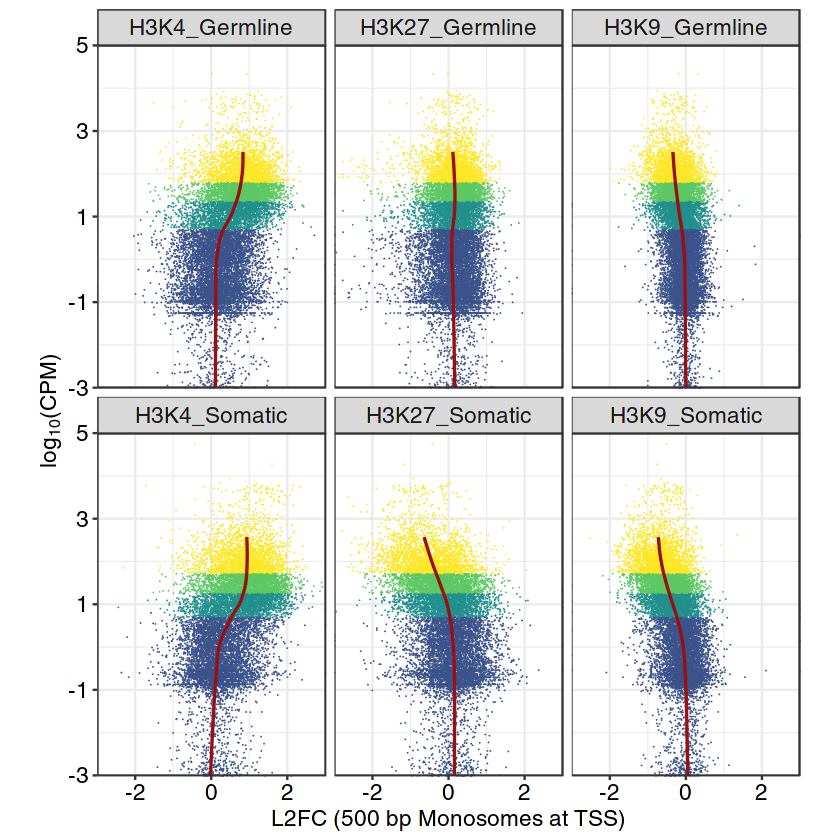

In [87]:
abundance_colors = viridisLite::viridis(5)[-1]
marks %>%
  ggplot() +
  geom_point(
    aes(L2FC, logCPM, color=color),
    size = 0.25, stroke=NA
  ) +
  # geom_segment(
  #   aes(x, y, xend = xend, yend = yend),
  #   data = marktrend,
  #   color = "black"
  # ) +
  # geom_ribbon(
  #   aes(x, ymin = ymin, ymax = ymax, fill = color),
  #   data = markribbon,
  #   alpha = 0.25
  # ) +
  # geom_line(
  #   aes(x, y, group = interaction(group, color)),
  #   data = markribbon,
  #   linewidth = 0.5 * 25.4 / 72
  # ) +
  geom_path(
    aes(L2FC, logCPM, group=group),
    data = markloess,
    color = "#991010",
    linewidth = 25.4 / 72 * 2
  ) +
  facet_wrap(vars(group), nrow=2, ncol=3, drop = F) +
  scale_x_continuous(breaks = c(-2, 0, 2), limits = xlim, oob = squish, expand = FALSE) +
  scale_y_continuous(breaks = seq(-3, 5, by = 2)) +
  scale_color_manual(values = abundance_colors) +
  scale_fill_manual(values = muted(abundance_colors, c = 80, l = 30)) +
  coord_cartesian(NULL, c(-3, 5), expand = FALSE) +
  labs(x = "L2FC (500 bp Monosomes at TSS)", y = bquote(log[10]*"(CPM)")) +
  theme(aspect.ratio = 1.5)

In [70]:
marks %>%
  subset(mark == "H3K4me3") %>%
  group_by(celltype) %>% summarise(length(which(color == "high" & logCPM <= quantile(logCPM, 0.975, na.rm=T))) / length(which(color == "high")))

celltype,`/`(...)
<fct>,<dbl>
Germline,0.8391057
Somatic,0.8469704


In [88]:
library(ggrastr)
cairo_pdf("figure/Both-Cell-Types/CHIC-TSS-AllMarks-Scatter.pdf", w=5, h=5.5)
print(rasterise(last_plot(), layers="Point", dpi=300))
dev.off()

Warning message:
“Removed 20253 rows containing missing values (`geom_point()`).”


png 
  2

In [15]:
stats <- marks %>%
  group_by(group) %>%
  summarise(
    WithinOff = cor(L2FC[color == "off"], logCPM[color == "off"], use = "complete"),
    WithinLow =  cor(L2FC[color == "low"], logCPM[color == "low"], use = "complete"),
    WithinMedium =  cor(L2FC[color == "medium"], logCPM[color == "medium"], use = "complete"),
    WithinHigh =  cor(L2FC[color == "high"], logCPM[color == "high"], use = "complete"),
    SumOfSquaresBetween =  cor(
        (
          L2FC %>%
            split(color) %>%
            sapply(purrr::partial(mean, na.rm=T))
        )[color],
        (
          logCPM %>%
            split(color) %>%
            sapply(purrr::partial(mean, na.rm=T))
        )[color],
        use = "complete"
      )
  ) %>%
  print()

# A tibble: 6 × 6
  group          WithinOff WithinLow WithinMedium WithinHigh SumOfSquaresBetween
  <fct>              <dbl>     <dbl>        <dbl>      <dbl>               <dbl>
1 H3K4_Germline   -0.00961    0.108       0.00231    -0.102                0.982
2 H3K27_Germline  -0.0304     0.0396      0.0247     -0.130               -0.337
3 H3K9_Germline   -0.00993    0.0264      0.0140     -0.164                0.876
4 H3K4_Somatic     0.0339     0.130      -0.0115     -0.0564               0.957
5 H3K27_Somatic    0.0112    -0.0106     -0.0639     -0.179               -0.783
6 H3K9_Somatic    -0.00271   -0.0456     -0.108      -0.111               -0.959


In [13]:
write.table(
  stats %>% mutate(group = as.character(group)),
  "figure/Both-Cell-Types/CHIC-TSS-AllMarks-Scatter-Pearson-R.csv",
  sep = ",", quote = F, row.names = F
)

In [85]:
stats <- marks %>%
  group_by(group, color) %>%
  summarise(value = markloess[markloess$group == group[1] & markloess$logCPM == round(median(logCPM, na.rm=T), 2), ]$L2FC %>% round(3)) %>%
  dcast(group ~ color) %>%
  print()

`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.


           group    off    low medium   high
1  H3K4_Germline  0.120  0.547  0.732  0.824
2 H3K27_Germline  0.112  0.155  0.167  0.143
3  H3K9_Germline -0.023 -0.176 -0.247 -0.309
4   H3K4_Somatic  0.138  0.736  0.904  0.946
5  H3K27_Somatic  0.152 -0.038 -0.224 -0.465
6   H3K9_Somatic -0.021 -0.346 -0.512 -0.661


In [86]:
write.table(
  stats %>% mutate(group = as.character(group)),
  "figure/Both-Cell-Types/CHIC-TSS-AllMarks-Scatter-L2FC-Fit.csv",
  sep = ",", quote = F, row.names = F
)

## Histone Code Classification with Both-Cell-Types Single-Cell Classification

In [8]:
tar_load(chic.gene.enrichment)

Germline Classification

In [9]:
with(
  tibble(chic.gene.enrichment, as_tibble(Upd_cpm)),
  table(
    K4 = H3K4_Germline < 0.001,
    K27 = H3K27_Germline < 0.001,
    activity = germline >= 5
  )
)

, , activity = FALSE

       K27
K4      FALSE TRUE
  FALSE  8000 1903
  TRUE    462  301

, , activity = TRUE

       K27
K4      FALSE TRUE
  FALSE  3313 1071
  TRUE   1586  844


Somatic Classification

In [10]:
with(
  tibble(chic.gene.enrichment, as_tibble(Upd_cpm)),
  table(
    K4 = H3K4_Somatic < 0.001,
    K27 = H3K27_Somatic < 0.001,
    activity = somatic >= 5
  )
)

, , activity = FALSE

       K27
K4      FALSE TRUE
  FALSE  8287  846
  TRUE   1028  561

, , activity = TRUE

       K27
K4      FALSE TRUE
  FALSE  2121  117
  TRUE   3973  547


In [11]:
with(
  tibble(chic.gene.enrichment, as_tibble(Upd_cpm)),
  table(
    interaction(H3K4_Somatic < 0.001, H3K27_Somatic < 0.001)[somatic >= 5]
  )
)


FALSE.FALSE  TRUE.FALSE  FALSE.TRUE   TRUE.TRUE 
       2121        3973         117         547 

# A tibble: 15,620 × 3
   celltype histone  tx              
   <chr>    <fct>    <fct>           
 1 Germline NA       NonExclusive    
 2 Germline ~        SomaticExclusive
 3 Germline ~        NonExclusive    
 4 Germline ~        NonExclusive    
 5 Germline ~        SomaticExclusive
 6 Germline ~        NonExclusive    
 7 Germline bivalent NonExclusive    
 8 Germline ~        NonExclusive    
 9 Germline ~        NonExclusive    
10 Germline ~        NonExclusive    
# ℹ 15,610 more rows


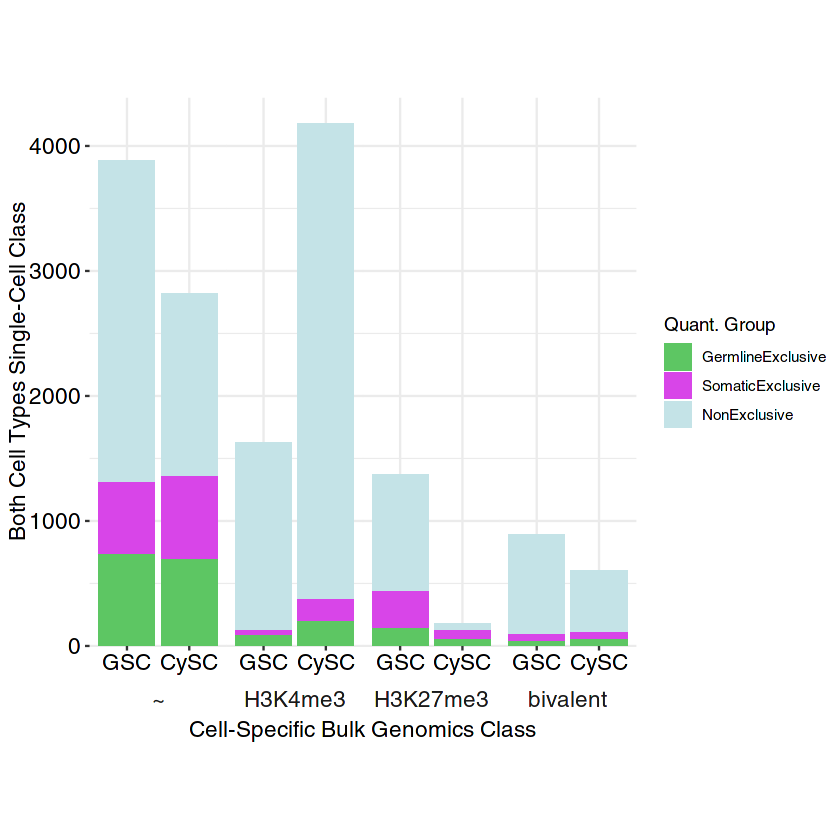

In [22]:
data <- with(
  tibble(chic.gene.enrichment, germline = quartile.factor_Germline, somatic = quartile.factor_Somatic),
  rbind(
    tibble(
      celltype = "Germline",
      histone = interaction(H3K4_Germline < 0.001, H3K27_Germline < 0.001),
      tx = interaction(quartile.factor_Germline != "Q1", quartile.factor_Somatic != "Q1"),
    ),
    tibble(
      celltype = "Somatic",
      histone = interaction(H3K4_Somatic < 0.001, H3K27_Somatic < 0.001),
      tx = interaction(quartile.factor_Germline != "Q1", quartile.factor_Somatic != "Q1"),
    )
  )
) %>%
  subset(tx != "FALSE.FALSE") %>%
  mutate(
    histone = histone %>%
      structure(
        levels = c("~", "H3K4me3", "H3K27me3", "bivalent"),
        class = "factor"
      ),
    tx = tx %>%
      structure(
        levels = c("off", "GermlineExclusive", "SomaticExclusive", "NonExclusive"),
        class = "factor"
      ),
  ) %>%
  print()
quant_color <- c(
  germline = "#5DC663",
  somatic = "#D845E8" , nonexclusive = "#c4e3e7"
)
n <- group_by(data, celltype, histone) %>% tally() %>% pull(n) %>% max()
data %>%
  subset(!is.na(histone)) %>%
  mutate(celltype = celltype %>% factor() %>% recode(Germline="GSC", Somatic="CySC")) %>%
  ggplot(aes(celltype, fill=tx)) +
  facet_grid(~histone, switch="x") +
  geom_bar(pos = position_stack(rev=T)) +
  scale_fill_manual(values = setNames(quant_color, NULL)) +
  coord_cartesian(c(0.4, 2.6), c(0, n * 1.05), expand=F) +
  labs(x = "Cell-Specific Bulk Genomics Class", y = "Both Cell Types Single-Cell Class", fill = "Quant. Group") +
  theme(
    aspect.ratio = 4,
    legend.position = "right",
    panel.border = element_rect(color = NA),
    panel.spacing = unit(-.01,"cm"),
    strip.background = element_rect(fill = NA, color = NA),
    strip.placement = "outside"
  )

In [32]:
cairo_pdf("figure/Both-Cell-Types/CHIC-Exclusive-Gene-Expression-Bar-Plot.pdf", w=7.75, height=5)
cowplot::plot_grid(
  set_panel_size(last_plot(), w=unit(1.25,"in"), h=unit(3.75,"in"))
)
dev.off()

png 
  2

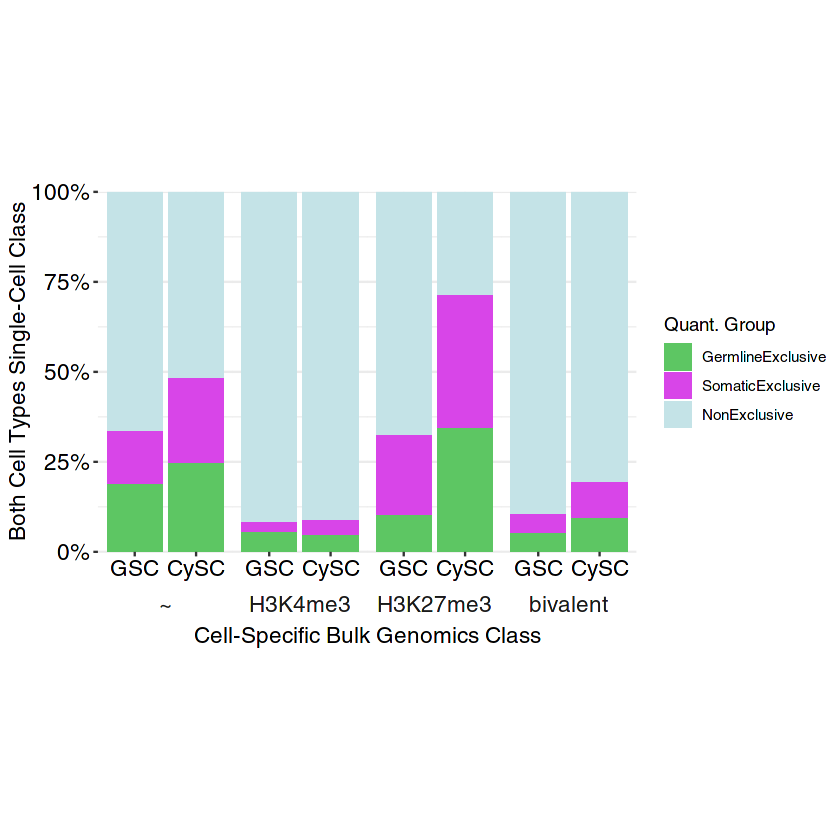

In [33]:
data %>%
  subset(!is.na(histone)) %>%
  mutate(celltype = celltype %>% factor() %>% recode(Germline="GSC", Somatic="CySC")) %>%
  ggplot(aes(celltype, fill=tx)) +
  facet_grid(~histone, switch="x") +
  geom_bar(position = position_fill(rev=T)) +
  scale_y_continuous(labels = percent) +
  scale_fill_manual(values = setNames(quant_color, NULL)) +
  coord_cartesian(c(0.4, 2.6), c(0, 1), expand=F) +
  labs(x = "Cell-Specific Bulk Genomics Class", y = "Both Cell Types Single-Cell Class", fill = "Quant. Group") +
  theme(
    aspect.ratio = 4 * 2/3,
    legend.position = "right",
    panel.border = element_rect(color = NA),
    panel.spacing = unit(-.01,"cm"),
    strip.background = element_rect(fill = NA, color = NA),
    strip.placement = "outside"
  )

In [34]:
cairo_pdf("figure/Both-Cell-Types/CHIC-Exclusive-Gene-Expression-Bar-Plot-Percent.pdf", w=7.75, height=5)
cowplot::plot_grid(
  set_panel_size(last_plot(), w=unit(1.25,"in"), h=unit(3.75,"in"))
)
dev.off()

png 
  2

In [36]:
summary <- data %>%
  group_by(histone, celltype, tx) %>%
  tally() %>%
  print()
colnames(summary) <- c("BulkGenomicsClass", "CellType", "TranscriptomeClass", "Count")
write.table(
  summary,
  "figure/Both-Cell-Types/CHIC-Exclusive-Gene-Expression-Contingency.csv",
  sep = ",", quote = F, row.names = F
)

# A tibble: 30 × 4
# Groups:   histone, celltype [10]
   histone celltype tx                    n
   <fct>   <chr>    <fct>             <int>
 1 ~       Germline GermlineExclusive   738
 2 ~       Germline SomaticExclusive    574
 3 ~       Germline NonExclusive       2575
 4 ~       Somatic  GermlineExclusive   699
 5 ~       Somatic  SomaticExclusive    667
 6 ~       Somatic  NonExclusive       1454
 7 H3K4me3 Germline GermlineExclusive    94
 8 H3K4me3 Germline SomaticExclusive     41
 9 H3K4me3 Germline NonExclusive       1492
10 H3K4me3 Somatic  GermlineExclusive   204
# ℹ 20 more rows
